In [1]:
# UOC
# Grado de Ingeniería Informática
# Inteligencia Artificial
# TFG - Aplicación de Técnicas de Explicabilidad (XAI) y Cuantificación de Incertidumbre (UQ) en la Predicción del Síndrome Metabólico mediante Aprendizaje Automático
# Xema Belmonte Marín

# Cuantificación de la incertidumbre del modelo (UQ)

Deseamos ahora que el modelo seleccionado nos informe sobre la incertidumbre asociada a sus predicciones. El mero pronóstico de la clase ya no basta, sino que queremos averiguar la verdadera probabilidad asociada a cada una. Esto se consigue calibrando el modelo, lo que nos brinda una estimación de la confianza en la predicción. En este cuaderno visualizaremos y calcularemos primero las métricas apropiadas para poder medir la calidad de la calibración. A continuación, aplicaremos Predicción Conforme como técnica de UQ (*Uncertainty Quantification*) a los resultados del modelo seleccionado para la tarea de clasificación binaria. Concretamente, se calibrará este modelo mediante *Venn-ABERs Conformal Prediction*, con el que generaremos probabilidades bien calibradas e intervalos de predicción para el diagnóstico de síndrome metabólico. Finalmente, aplicaremos técnicas de XAI local, especialmente en aquellas predicciones menos confiables.

## Librerías y funciones

### Import libraries

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn: modelo de aprendizaje automático
from sklearn.ensemble import RandomForestClassifier

# Scikit-learn: evaluación
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import FixedThresholdClassifier
from sklearn.metrics import brier_score_loss, log_loss

# Scikit-learn: calibración
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.calibration import CalibratedClassifierCV

# XAI: interpretación del modelo
import shap
import dice_ml as dice

%matplotlib inline

### Funciones

In [3]:
# Opciones generales

# Desactivar warnings
warnings.filterwarnings("ignore")

# Tamaño de letra en los gráficos
font = {'size': 12}
plt.rc('font', **font)

# Mostramos 3 decimales en las tablas
pd.options.display.float_format = '{:.3f}'.format

In [4]:
def plot_calibration_curves(clf_list, y_test, n_bins=10, strategy='uniform'):
    """
    Muestra un gráfico con las curvas de calibración para la lista de tuplas pasada
    clf_list contiene los raw scores de los modelos y sus nombres
    """
    plt.figure(figsize=(10, 5))
    palette = ['#009E73', '#E69F00', '#2FC1D3', '#076FA1']
    
    for i, (y_raw_score, name) in enumerate(clf_list):
        # Calculamos los valores de las curvas de calibración
        binned_true_p, binned_predict_p = calibration_curve(y_test, y_raw_score, n_bins=n_bins, strategy=strategy)
        
        # Visualizamos las curvas
        CalibrationDisplay(binned_true_p, binned_predict_p, y_raw_score).plot(ax=plt.gca(), name=name, color=palette[i])
    
    plt.grid()
    plt.tight_layout(pad=1)
    plt.show()

In [5]:
# Straight-forward implementation of IVAP algorithm described in:
# Large-scale probabilistic prediction with and without validity guarantees, Vovk et al.
# https://arxiv.org/pdf/1511.00213.pdf
#
# Paolo Toccaceli
#
# https://github.com/ptocca/VennABERS
#
# 2020-07-09: Fixed bug in p0 calculation

# Some elementary functions to speak the same language as the paper
# (at some point we'll just replace the occurrence of the calls with the function body itself)
def push(x,stack):
    stack.append(x)

    
def pop(stack):
    return stack.pop()


def top(stack):
    return stack[-1]


def nextToTop(stack):
    return stack[-2]


# perhaps inefficient but clear implementation
def nonleftTurn(a,b,c):   
    d1 = b-a
    d2 = c-b
    return np.cross(d1,d2)<=0


def nonrightTurn(a,b,c):   
    d1 = b-a
    d2 = c-b
    return np.cross(d1,d2)>=0


def slope(a,b):
    ax,ay = a
    bx,by = b
    return (by-ay)/(bx-ax)


def notBelow(t,p1,p2):
    p1x,p1y = p1
    p2x,p2y = p2
    tx,ty = t
    m = (p2y-p1y)/(p2x-p1x)
    b = (p2x*p1y - p1x*p2y)/(p2x-p1x)
    return (ty >= tx*m+b)

kPrime = None

# Because we cannot have negative indices in Python (they have another meaning), I use a dictionary

def algorithm1(P):
    global kPrime
    
    S = []
    P[-1] = np.array((-1,-1))
    push(P[-1],S)
    push(P[0],S)
    for i in range(1,kPrime+1):
        while len(S)>1 and nonleftTurn(nextToTop(S),top(S),P[i]):
            pop(S)
        push(P[i],S)
    return S


def algorithm2(P,S):
    global kPrime
    
    Sprime = S[::-1]     # reverse the stack

    F1 = np.zeros((kPrime+1,))
    for i in range(1,kPrime+1):
        F1[i] = slope(top(Sprime),nextToTop(Sprime))
        P[i-1] = P[i-2]+P[i]-P[i-1]
        if notBelow(P[i-1],top(Sprime),nextToTop(Sprime)):
            continue
        pop(Sprime)
        while len(Sprime)>1 and nonleftTurn(P[i-1],top(Sprime),nextToTop(Sprime)):
            pop(Sprime)
        push(P[i-1],Sprime)
    return F1


def algorithm3(P):
    global kPrime

    S = []
    push(P[kPrime+1],S)
    push(P[kPrime],S)
    for i in range(kPrime-1,0-1,-1):  # k'-1,k'-2,...,0
        while len(S)>1 and nonrightTurn(nextToTop(S),top(S),P[i]):
            pop(S)
        push(P[i],S)
    return S


def algorithm4(P,S):
    global kPrime
    
    Sprime = S[::-1]     # reverse the stack
    
    F0 = np.zeros((kPrime+1,))
    for i in range(kPrime,1-1,-1):   # k',k'-1,...,1
        F0[i] = slope(top(Sprime),nextToTop(Sprime))
        P[i] = P[i-1]+P[i+1]-P[i]
        if notBelow(P[i],top(Sprime),nextToTop(Sprime)):
            continue
        pop(Sprime)
        while len(Sprime)>1 and nonrightTurn(P[i],top(Sprime),nextToTop(Sprime)):
            pop(Sprime)
        push(P[i],Sprime)
    return F0


def prepareData(calibrPoints):
    global kPrime
    
    ptsSorted = sorted(calibrPoints)
    
    xs = np.fromiter((p[0] for p in ptsSorted),float)
    ys = np.fromiter((p[1] for p in ptsSorted),float)
    ptsUnique,ptsIndex,ptsInverse,ptsCounts = np.unique(xs, 
                                                        return_index=True,
                                                        return_counts=True,
                                                        return_inverse=True)
    a = np.zeros(ptsUnique.shape)
    np.add.at(a,ptsInverse,ys)
    # now a contains the sums of ys for each unique value of the objects
    
    w = ptsCounts
    yPrime = a/w
    yCsd = np.cumsum(w*yPrime)   # Might as well do just np.cumsum(a)
    xPrime = np.cumsum(w)
    kPrime = len(xPrime)
    
    return yPrime,yCsd,xPrime,ptsUnique


def computeF(xPrime,yCsd):
    global kPrime
    P = {0:np.array((0,0))}
    P.update({i+1:np.array((k,v)) for i,(k,v) in enumerate(zip(xPrime,yCsd))})
    
    S = algorithm1(P)
    F1 = algorithm2(P,S)
    
    P = {0:np.array((0,0))}
    P.update({i+1:np.array((k,v)) for i,(k,v) in enumerate(zip(xPrime,yCsd))})    
    P[kPrime+1] = P[kPrime] + np.array((1.0,0.0))    # The paper says (1,1)
    
    S = algorithm3(P)
    F0 = algorithm4(P,S)
    
    return F0,F1


def getFVal(F0,F1,ptsUnique,testObjects):
    pos0 = np.searchsorted(ptsUnique,testObjects,side='left')
    pos1 = np.searchsorted(ptsUnique[:-1],testObjects,side='right')+1
    return F0[pos0],F1[pos1]


def ScoresToMultiProbs(calibrPoints,testObjects):
    # sort the points, transform into unique objects, with weights and updated values
    yPrime,yCsd,xPrime,ptsUnique = prepareData(calibrPoints)
    
    # compute the F0 and F1 functions from the CSD
    F0,F1 = computeF(xPrime,yCsd)
    
    # compute the values for the given test objects
    p0,p1 = getFVal(F0,F1,ptsUnique,testObjects)
                    
    return p0,p1

In [6]:
def plot_case(pred_df, special_cases=[]):
    """
    Muestra los casos pasados en el gráfico de predicciones tras IVAP
    special_cases es una lista de diccionarios conteniendo:
    el index del dataframe de las predicciones y el label para el caso específico
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    plt.scatter(x=pred_df.index, y=pred_df['probability_of_metabolic_syndrome'], label='p', s=6)
    plt.scatter(x=pred_df.index, y=pred_df['metabolic_syndrome'], label='ground truth', s=2, color='black')
    plt.plot(pred_df.index, pred_df["width_of_prediction_interval"], label="p1-p0", lw=0.8, color="green")
    plt.axhline(y=alpha, color='red', linewidth=1, label='alpha', alpha=0.3)
    plt.legend()
    
    # Resaltamos los casos pasados
    for case in special_cases:
        index = case['index']
        label = case.get('label', 'Special Case')
        
        plt.scatter(index, pred_df.loc[index, 'probability_of_metabolic_syndrome'], color='#E69F00', label=label, s=50, edgecolor='black')
        plt.annotate(label, (index, pred_df.loc[index, 'probability_of_metabolic_syndrome']), textcoords="offset points", xytext=(2, 6))

    plt.ylabel("Probability")
    plt.xlabel("Test set ordered by conformal probability")
    plt.xticks([])
    plt.grid(alpha=0.3)
    plt.tight_layout(pad=1)
    plt.show()

In [7]:
def plot_case_xai(explainer, choosen_case):
    """
    Muestra las contribuciones de los valores SHAP para una predicción individual
    """
    shap_values = explainer.shap_values(choosen_case)

    # SHAP force plot
    return shap.force_plot(explainer.expected_value[1], shap_values[..., 1], choosen_case)

## Entrenamiento del modelo seleccionado

Recordamos que tenemos el conjunto de datos dividido en un *set* de entrenamiento, uno de calibración y uno de prueba, que corresponden al 75%, 20% y 5% del *dataset*, respectivamente. Contienen datos demográficos y clínicos de personas etiquetadas con el diagnóstico de síndrome metabólico.

In [8]:
# Cargamos los conjuntos de datos preprocesados
X_train = pd.read_csv('metabolic_syndrome_x_train.csv')
y_train = pd.read_csv('metabolic_syndrome_y_train.csv')
X_test = pd.read_csv('metabolic_syndrome_x_test.csv')
y_test = pd.read_csv('metabolic_syndrome_y_test.csv')
X_cal = pd.read_csv('metabolic_syndrome_x_cal.csv')
y_cal = pd.read_csv('metabolic_syndrome_y_cal.csv')

El modelo seleccionado es un bosque aleatorio con el umbral de decisión ajustado a 0,202.

In [9]:
# Modelo seleccionado
model = RandomForestClassifier(
    n_estimators=300,
    criterion='entropy',
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=5,
    max_features=None,
    random_state=23,
)
threshold = 0.202

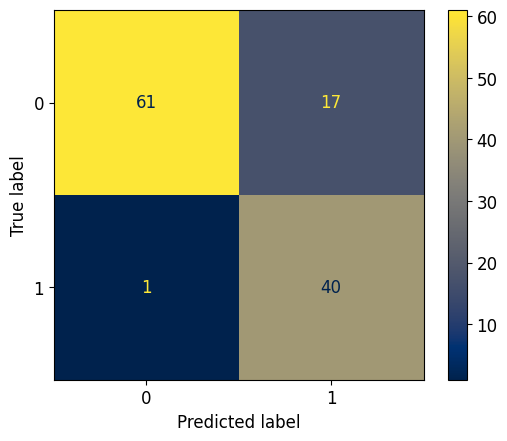

In [10]:
# Entrenamos el modelo y mostramos la matriz de confusión con las predicciones sobre el conjunto de prueba
model.fit(X_train, y_train)
model_t = FixedThresholdClassifier(model, threshold=threshold, response_method="predict_proba").fit(X_train, y_train)
ConfusionMatrixDisplay.from_predictions(y_test, model_t.predict(X_test), cmap = 'cividis')

Recordamos también que las predicciones probabilísticas que arrojan los modelos de aprendizaje automático no son verdaderas probabilidades, sino puntuaciones crudas sin calibrar. Lo estarían si, por ejemplo, dada una puntuación del 90%, encontramos la clase positiva 9 de cada 10 veces.

In [11]:
# Obtenemos las predicciones del modelo para los conjuntos de calibración y prueba
y_pred_cal = model_t.predict(X_cal)
y_pred_test = model_t.predict(X_test)
# También las puntuaciones crudas de la clase positiva
y_raw_score_cal = model_t.predict_proba(X_cal)[:, 1]
y_raw_score_test = model_t.predict_proba(X_test)[:, 1]

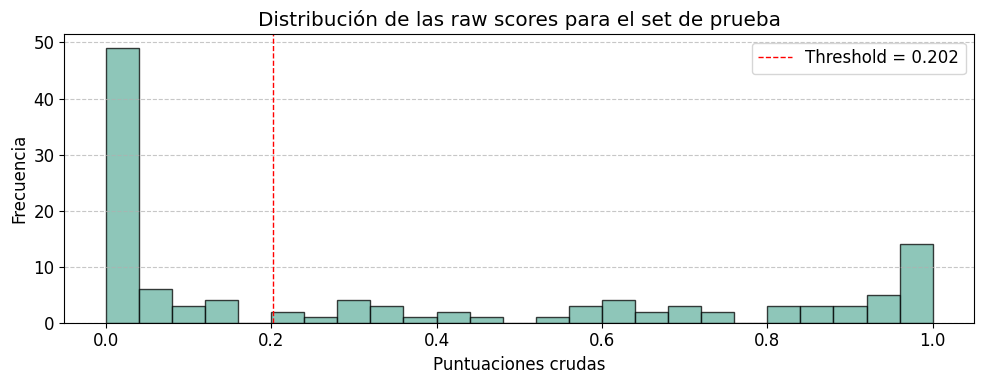

In [12]:
# Visualizamos la distribución de las raw scores para el set de prueba
plt.figure(figsize=(10, 4))
plt.hist(y_raw_score_test, bins=25, color='#69B3A2', edgecolor='black', alpha=0.75)

# Añadimos el umbral de decisión
plt.axvline(threshold, color='red', linestyle='--', linewidth=1, label=f"Threshold = {threshold}")

plt.title("Distribución de las raw scores para el set de prueba")
plt.xlabel("Puntuaciones crudas")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

El gráfico nos muestra que el modelo predice síndrome metabólico para aquellas *raw scores* mayores de 0,202, empleando el método `model_t.predict()`. En este conjunto de prueba, significa que 57 instancias se clasifican con "1" y 62 con "0", así que prácticamente el umbral marca la línea que divide al ~50% las observaciones.

## Estrategia "naïve"

Si [tomaramos un enfoque ingenuo para la incertidumbre](https://mindfulmodeler.substack.com/p/week-1-getting-started-with-conformal), es decir, creer que las puntuaciones que arroja el método `predict_proba()` son verdaderas probabilidades, entonces en vez de usar la clase, tomaríamos estas *raw scores* y, si son mayores de 0,9, interpretaríamos que 9 de cada 10 son correctas. Es decir, el modelo predice la clase positiva el 90% de las veces. Testearemos esta idea con el conjunto de prueba, obteniendo primero las puntuaciones crudas y seleccionando aquellas que son mayores o iguales a 0,90. Luego, comprobamos que la frecuencia de la *ground truth* sea ese 90%, calculando así la cobertura (*coverage*): la proporción de predicciones correctas entre las instancias para las que la puntuación más alta que ha arrojado el modelo fue al menos del 90%.

In [13]:
# Obtenemos los raw scores mayores que 0,90 para la clase positiva
confidence_scores = np.where(y_raw_score_test >= 0.90)
# Calculamos la proporción de las veces que se ha acertado la clase
correct_pred = (y_pred_test == np.array(y_test).flatten())
correct_confidence_pred = correct_pred[confidence_scores]
coverage = np.mean(correct_confidence_pred)
# Este último cálculo es equivalente a...
# coverage = correct_confidence_pred.sum() / len(correct_confidence_pred)
# ...para arrays booleanos
print(f"Coverage at 90% confidence: {round(coverage, 3)}")

Coverage at 90% confidence: 0.905


Este resultado puede sugerir que el modelo que hemos obtenido está en cierto grado bien calibrado. No hemos tratado con un juego de datos complejo para que el proceso pudiera generar un bosque aleatorio muy mal calibrado. Si fuese ese el caso, hubieramos esperado un número menor a 0,9, encontrando que el 90% de los diagnosticos de síndrome metabólico solo contendría el `coverage*100`% de los casos correctamente diagnosticados. De todas maneras, este método no garantiza la cobertura matemática, por lo que es necesario calibrar el modelo.

Cuando nos decidimos por un 90% de confianza, establecemos el llamado nivel de significación (alfa) a 0,1. Esto indica que aceptamos un 10% de errores en las predicciones. En general, para resultados con un nivel de confianza del $\varepsilon$ por ciento, el valor de alfa (𝛂) es: $\alpha = 1 - (\frac{\varepsilon}{100})$

## Curvas de calibración

La calibración consiste en agrupar las probabilidades que arroja una predicción y compararlas con la proporción real del suceso, es decir, la *ground truth*. Una curva de calibración traza entonces las predicciones frente a la tasa real de ocurrencia. El método `calibration_curve` realiza este cómputo agrupando en intervalos las *raw scores* similares y calculando con qué frecuencia ocurre la clase positiva en ese intervalo. Veamos qué tal están calibradas las puntuaciones crudas en el conjunto de prueba utilizando estas curvas.

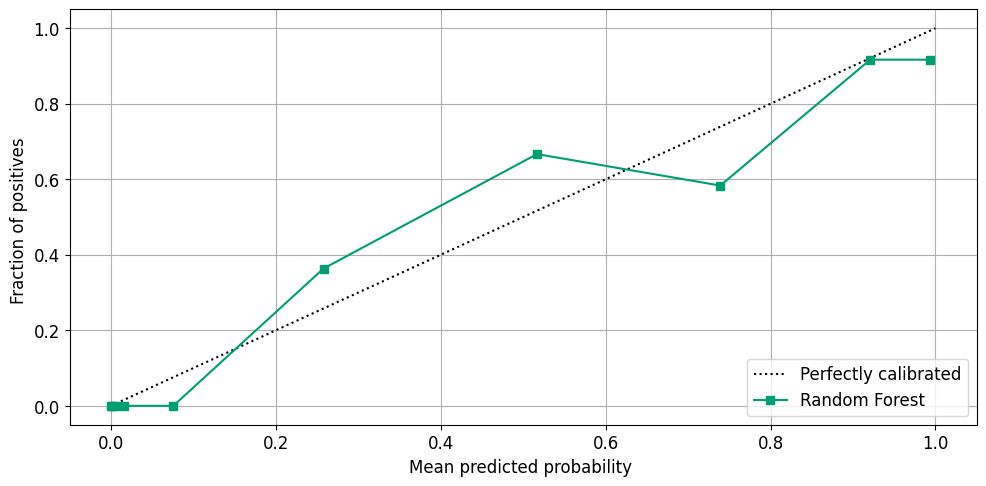

In [14]:
# Visualizamos las curvas de calibración
clf_list = [
    (y_raw_score_test, "Random Forest"),
]
plot_calibration_curves(clf_list, y_test, n_bins=10, strategy='quantile')

Cuanto más se alineen los puntos a la línea diagonal discontinua, mejor calibrado estará el modelo y mejores serán las probabilidades predichas. La forma de la curva indica que el clasificador subestima para puntuaciones bajas y medias y sobreestima cuando las "probabilidades" son altas. Por ejemplo, para las observaciones para las que el modelo predijo una puntuación del 100% de ser positivas, éstas son realmente del ~90%. Por el contrario, cuando predice con un ~25% de ser positiva (1 de 4), en verdad lo son casi el ~40%.

## Métricas

Analizaremos el rendimiento predictivo en el conjunto de prueba utilizando las métricas habituales: *accuracy*, F1-score, *precision*, *recall* y el área bajo la curva ROC (AUC). Para medir la calidad de la calibración usarermos la función *log loss* y la puntuación *Brier loss*. Ambas métricas son mejores cuanto menores sean, de ahí el *loss* (pérdida) en sus nombres, y van entre 0 y 1, con lo que cuanto más cercanas a 0 estén, mejor indicarán que es la calibración.

In [15]:
# Obtenemos las métricas
metrics = {
        'Metric': ['Accuracy', 'F1-score', 'Recall', 'Precision', 'ROC AUC', 'Brier Score', 'Log loss'],
        'Random Forest': [
            accuracy_score(y_test, y_pred_test), 
            f1_score(y_test, y_pred_test),
            recall_score(y_test, y_pred_test),
            precision_score(y_test, y_pred_test),
            roc_auc_score(y_test, y_raw_score_test),
            brier_score_loss(y_test, y_raw_score_test),
            log_loss(y_test, y_raw_score_test)
        ]
    }

# Mostramos tabla con los valores de las métricas
metrics_test = pd.DataFrame(metrics).round(3)
display(metrics_test.style.hide(axis="index"))

Metric,Random Forest
Accuracy,0.849000
F1-score,0.816000
Recall,0.976000
Precision,0.702000
ROC AUC,0.945000
Brier Score,0.092000
Log loss,0.287000


Los resultados de las métricas de rendimiento ya los conocíamos del cuaderno anterior. Hemos añadido el 0,092 del *Brier score* y el 0,287 del *log loss*, que deberían disminuir si se consigue mejorar la calibración.

## Calibración con Platt Scaling e Isotonic Regression

Convencionalmente, la calibración de un clasificador consiste en ajustar una función (un regresor) que asigna las predicciones del modelo a una probabilidad calibrada de 0 a 1. En nuestro caso asignaremos la salida de `predict_proba()`, usando `CalibratedClassifierCV`, que soporta dos tipos de técnicas a través del parámetro `method`. Para `sigmoid` se basa en el escalado de Platt, que funciona bien cuando la curva de calibración es sigmoide, y para `isotonic` se basa en la regresión isotónica, que ajusta un conjunto a través de una función creciente.

In [16]:
# Entrenamos los calibradores y obtenemos las raw scores
rf_isotonic = CalibratedClassifierCV(model_t, cv=5, method="isotonic")
rf_platt = CalibratedClassifierCV(model_t, cv=5, method="sigmoid")

rf_isotonic.fit(X_train, y_train)
y_raw_score_rf_isotonic = rf_isotonic.predict_proba(X_test)[:,1]

rf_platt.fit(X_train, y_train)
y_raw_score_rf_platt = rf_platt.predict_proba(X_test)[:,1]

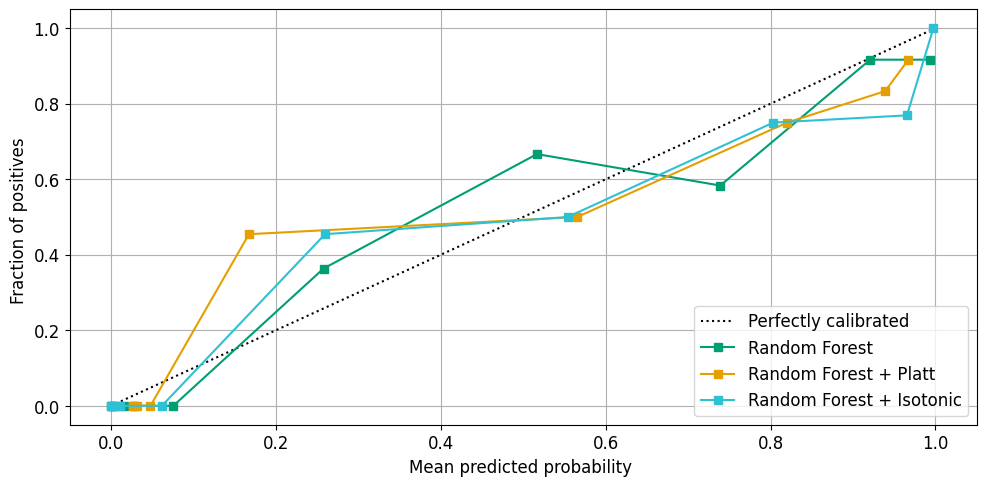

In [17]:
# Mostramos las curvas de calibración
clf_list = [
    (y_raw_score_test, "Random Forest"),
    (y_raw_score_rf_platt, "Random Forest + Platt"),
    (y_raw_score_rf_isotonic, "Random Forest + Isotonic"),
]

plot_calibration_curves(clf_list, y_test, n_bins=10, strategy='quantile')

No se aprecia que la calibración inicial haya mejorado o empeorado. Calculemos las métricas:

In [18]:
# Métricas para Platt scaling e isotonic regression
y_pred_rf_platt = rf_platt.predict(X_test)
metrics_platt = [
    accuracy_score(y_test, y_pred_rf_platt), 
    f1_score(y_test, y_pred_rf_platt),
    recall_score(y_test, y_pred_rf_platt),
    precision_score(y_test, y_pred_rf_platt),
    roc_auc_score(y_test, y_raw_score_rf_platt),
    brier_score_loss(y_test, y_raw_score_rf_platt),
    log_loss(y_test, y_raw_score_rf_platt)
]

y_pred_rf_isotonic = rf_isotonic.predict(X_test)
metrics_isotonic = [
    accuracy_score(y_test, y_pred_rf_isotonic), 
    f1_score(y_test, y_pred_rf_isotonic),
    recall_score(y_test, y_pred_rf_isotonic),
    precision_score(y_test, y_pred_rf_isotonic),
    roc_auc_score(y_test, y_raw_score_rf_isotonic),
    brier_score_loss(y_test, y_raw_score_rf_isotonic),
    log_loss(y_test, y_raw_score_rf_isotonic)
]

# Las agregamos a la tabla de métricas existente
metrics['Random Forest + Platt'] = metrics_platt
metrics['Random Forest + Isotonic'] = metrics_isotonic

metrics_combined = pd.DataFrame(metrics).round(3)
display(metrics_combined.style.hide(axis="index"))

Metric,Random Forest,Random Forest + Platt,Random Forest + Isotonic
Accuracy,0.849000,0.882000,0.882000
F1-score,0.816000,0.837000,0.837000
Recall,0.976000,0.878000,0.878000
Precision,0.702000,0.800000,0.800000
ROC AUC,0.945000,0.945000,0.945000
Brier Score,0.092000,0.095000,0.093000
Log loss,0.287000,0.303000,0.297000


Fijándonos en las puntuaciones de las funciones de pérdida, podemos afirmar que no se ha mejorado la calibración del modelo. Hay una pequeña diferencia en la *accuracy* a raíz de disminuir *recall* en pos de *precision*, pero para la ROC AUC no beneficia haber calibrado.

Aplicaremos ahora *conformal prediction* para calibrar el modelo, no solo por probar otro método que pueda ser más efectivo, sino por una característica de la que carecen las técnicas anteriores: no solo se convertirán las *raw scores* en verdaderas probabilidades, sino que también se obtendrán intervalos de predicción, con lo que podremos cuantificar la incertidumbre.

## Calibración con Venn-ABERS

Dentro de los métodos de Predicción Conforme, emplearemos [Venn-ABERS para calibrar](https://www.kaggle.com/code/carlmcbrideellis/classifier-calibration-using-venn-abers#Cross-Venn-ABERS-prediction) nuestro modelo y producir intervalos de predicción bien calibrados para las probabilidades de clase. La amplitud de estos intervalos refleja la incertidumbre de las predicciones. Independientemente del modelo, el tamaño de la muestra y la distribución de los datos, Venn-ABERS genera dos predicciones de probabilidad para cada ejemplo del conjunto de prueba, que se pueden entonces consolidar en una única probabilidad de clase.

El método que utilizaremos aquí es la forma inductiva de *Venn-ABERS Preditor* (IVAP), que se basa en un conjunto de calibración, con el que se comparan las puntuaciones crudas del modelo con las etiquetas de las clases sobre este *set*.

In [19]:
# Necesitamos trabajar con numpy arrays
y_cal = y_cal.to_numpy()

# Usamos el modelo entrenado con el conjunto de entrenamiento, pero predecimos con el de calibración
# y_pred_cal = model_t.predict(X_cal)
# y_raw_score_cal = model_t.predict_proba(X_cal)[:, 1]
# y_raw_score_test = model_t.predict_proba(X_test)[:, 1]

La función que implementa [Venn-ABERS Predictor](https://github.com/ptocca/VennABERS) es `ScoresToMultiProbs()`, que toma dos parámetros: `calibrPts`, una lista de tuplas con la puntuación cruda y la etiqueta de clase de los ejemplos de calibración, y `testScores`, una lista con las puntuaciones crudas de los ejemplos de prueba. La función devuelve un par de *arrays* NumPy con las predicciones probabilísticas.

In [20]:
# calibrPts: a list of pairs (score, label)
# score: lista de las puntuaciones crudas de la clase positiva (un número real) para el conjunto de calibración
# label: lista de las etiquetas de la clase (0 o 1), ground truth del conjunto de calibración
calibrPts = zip(list(y_raw_score_cal), list(y_cal))

# testScores: lista con puntuaciones crudas del conjunto de prueba
testScores = list(y_raw_score_test)

# Aplicamos la función del Venn-ABERS Predictor para obtener las predicciones probabilísticas
p0, p1 = ScoresToMultiProbs(calibrPts, testScores)

Tanto `p0` como `p1` representan la probabilidad de que la observación pertenezca a la clase positiva. Por lo tanto, forman un intervalo de predicción para la probabilidad bien calibrada de la clase "1", con garantía matemática de que la probabilidad real reside dentro de este rango. En la práctica, si tenemos que para una persona, la probabilidad de ser diagnosticada con síndrome metabólico está dentro del intervalo (p0, p1), podemos unificarlo para la toma de decisiones como `p = p1 /(1-p0+p1)`.

In [21]:
# Generamos un dataframe con las predicciones para el conjunto de prueba
pred_df = y_test.copy()
pred_df.columns = ['metabolic_syndrome']
pred_df['raw_scores'] = y_raw_score_test
pred_df['p0'] = p0
pred_df['p1'] = p1
pred_df['probability_of_metabolic_syndrome'] = p1/(1-p0+p1)
pred_df['width_of_prediction_interval'] = pred_df['p1'] - pred_df['p0']

In [22]:
# Mostramos las 10 observaciones con los valores más altos de width_of_prediction_interval
display(pred_df.nlargest(10, 'width_of_prediction_interval'))

,metabolic_syndrome,raw_scores,p0,p1,probability_of_metabolic_syndrome,width_of_prediction_interval
41,0,0.140,-0.000,0.242,0.195,0.242
22,0,0.137,-0.000,0.235,0.190,0.235
33,1,0.872,0.800,1.000,0.833,0.200
91,1,0.888,0.818,1.000,0.846,0.182
93,0,0.320,0.219,0.391,0.334,0.173
112,0,0.318,0.219,0.391,0.334,0.173
49,1,0.905,0.846,1.000,0.867,0.154
11,0,0.822,0.753,0.900,0.785,0.147
63,1,0.913,0.857,1.000,0.875,0.143
23,1,0.923,0.867,1.000,0.882,0.133


En la tabla vemos lo que serían los casos en los que el modelo tiene más dudas, esto es, tienen la mayor anchura en el intervalo (p0, p1). Visualicemos p0 y p1, el límite inferior y superior de la probabilidad calibrada de la clase positiva, junto con la diferencia de estos dos valores, que indica la incertidumbre de la predicción:

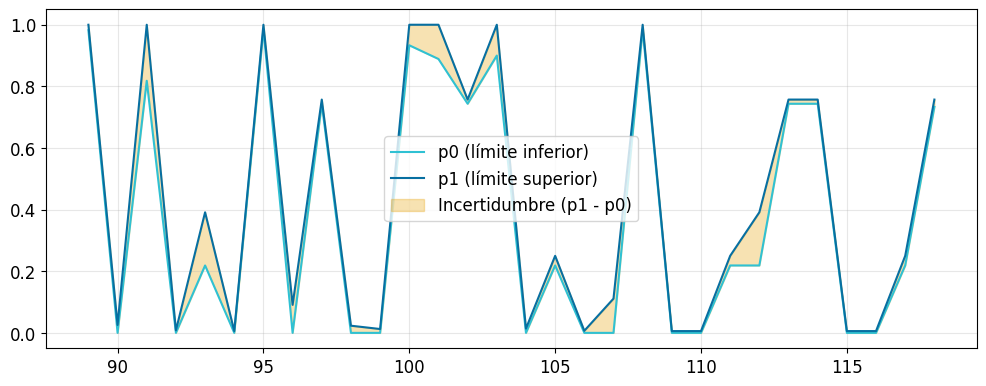

In [23]:
# Visualizamos los valores p0 y p1 de las últimas 30 observaciones junto con la diferencia
plt.figure(figsize=(10, 4))

plt.plot(pred_df[-30:].index, pred_df[-30:]['p0'], label='p0 (límite inferior)', color='#2FC1D3')
plt.plot(pred_df[-30:].index, pred_df[-30:]['p1'], label='p1 (límite superior)', color='#076FA1')

# Rellenamos la diferencia entre p0 y p1
plt.fill_between(pred_df[-30:].index, pred_df[-30:]['p0'], pred_df[-30:]['p1'], color='#E69F00', alpha=0.3, label='Incertidumbre (p1 - p0)')

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout(pad=1)
plt.show()

Las áreas rellenadas, que muestran la diferencia entre el límite superior de la probabilidad (p1) y el inferior (p0), capturan la incertidumbre de la predicción. Las mayores pertenecen a las instancias 91, 93 y 112 que ya nos aparecían en la lista anterior.

In [24]:
# Obtenemos la media de las anchuras de los intervalos
uncertainty_mean = pred_df['width_of_prediction_interval'].mean().round(3)
print(f"Media de la anchura de los intervalos de probabilidad: {uncertainty_mean}")

Media de la anchura de los intervalos de probabilidad: 0.04


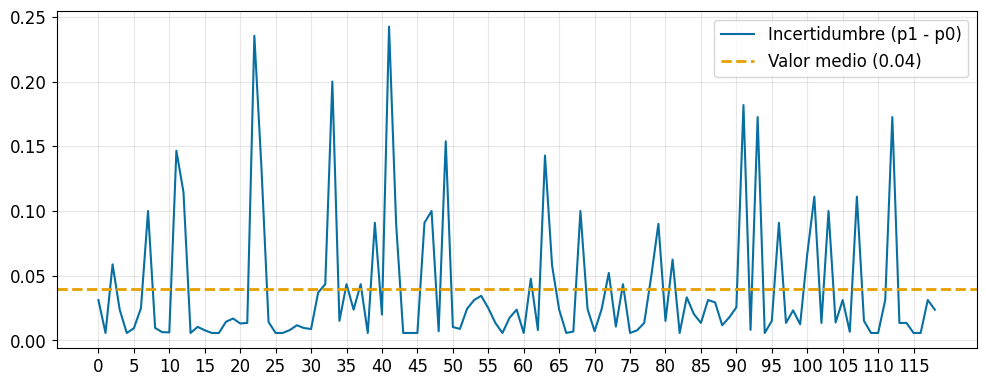

In [25]:
# Visualizamos la incertidumbre en todo el set de prueba junto con la línea de la media
plt.figure(figsize=(10, 4))

plt.plot(pred_df.index, pred_df['width_of_prediction_interval'], label='Incertidumbre (p1 - p0)', color='#076FA1')
plt.axhline(y=uncertainty_mean, color='#E69F00', linestyle='--', linewidth=2, label=f'Valor medio ({uncertainty_mean})')

plt.xticks(np.arange(0, len(pred_df) + 1, 5))
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout(pad=1)
plt.show()

Las instancias más alejadas de la línea de la media (0,04) representarían las más difíciles de predecir. Seguiremos analizando la confiabilidad de estas predicciones para detenernos en aquello casos más complicados, pero antes analizaremos la calibración realizada.

### Métricas

Mostramos la curva de calibración y volvemos a calcular las métricas tras la implementación de IVAP.

In [26]:
# Consolidamos la probabilidad
p = p1 /(1-p0+p1)

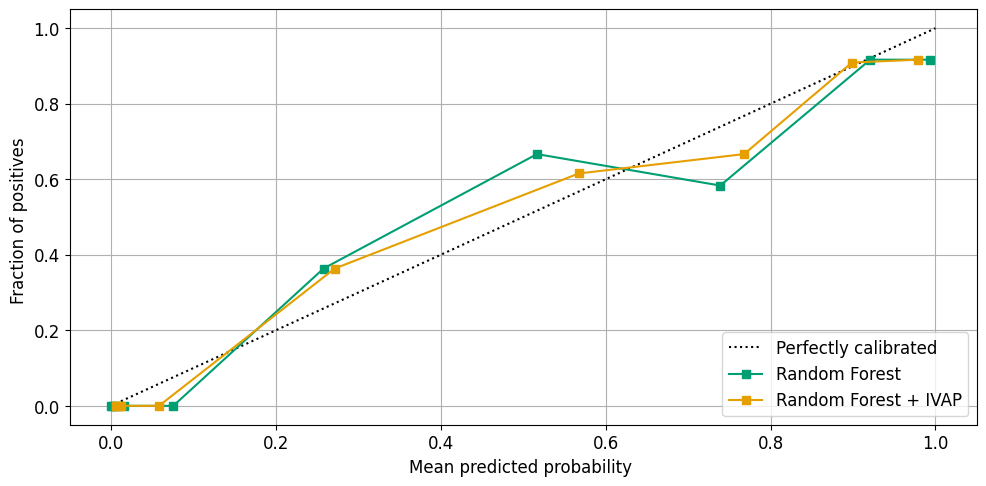

In [27]:
clf_list = [
    (y_raw_score_test, "Random Forest"),
    (p, "Random Forest + IVAP"),
]

plot_calibration_curves(clf_list, y_test, n_bins=10, strategy='quantile')

In [28]:
# Métricas para IVAP
metrics_ivap = [
    accuracy_score(y_test, p >= threshold), 
    f1_score(y_test, p >= threshold),
    recall_score(y_test, p >= threshold),
    precision_score(y_test, p >= threshold),
    roc_auc_score(y_test, p),
    brier_score_loss(y_test, p),
    log_loss(y_test, p)
]

# Append the ivap metrics to the existing metrics dictionary
metrics['Random Forest + IVAP'] = metrics_ivap
            
# Create and display the updated DataFrame
metrics_combined = pd.DataFrame(metrics).round(3)
display(metrics_combined.style.hide(axis="index"))

Metric,Random Forest,Random Forest + Platt,Random Forest + Isotonic,Random Forest + IVAP
Accuracy,0.849000,0.882000,0.882000,0.857000
F1-score,0.816000,0.837000,0.837000,0.828000
Recall,0.976000,0.878000,0.878000,1.000000
Precision,0.702000,0.800000,0.800000,0.707000
ROC AUC,0.945000,0.945000,0.945000,0.945000
Brier Score,0.092000,0.095000,0.093000,0.093000
Log loss,0.287000,0.303000,0.297000,0.284000


Las métricas de rendimiento han mejorado al conseguir, la conformalización con IVAP, clasificar correctamente todos los casos positivos, aunque no haya repercutido apenas en la calibración.

## Intervalos de predicción para alfa

Para el valor comentado de alfa de 0,1, que significa un nivel de confianza del 90%, se consideran aquellas predicciones cuya anchura del intervalo sea menor que 0,1. Vamos a generar un gráfico que muestre ordenadas las predicciones obtenidas por la probabilidad conforme `p`, para visualizar aquellas cuya incertidumbre esté situada por encima de esta alfa. Además, añadiremos una línea vertical que separará aquellas predicciones probabilísticas por encima del umbral de decisión, y que el modelo predice como positivas.

In [29]:
# Alfa para un nivel de confianza del 90%
alpha = 0.1

# Reordenamos por p
pred_df = pred_df.sort_values(by=['probability_of_metabolic_syndrome'])
pred_df = pred_df.reset_index()

# Obtenemos el índice de la primera instancia cuya p es mayor que el umbral de decisión
index_threshold = pred_df[pred_df['probability_of_metabolic_syndrome'] >= threshold].index[0]

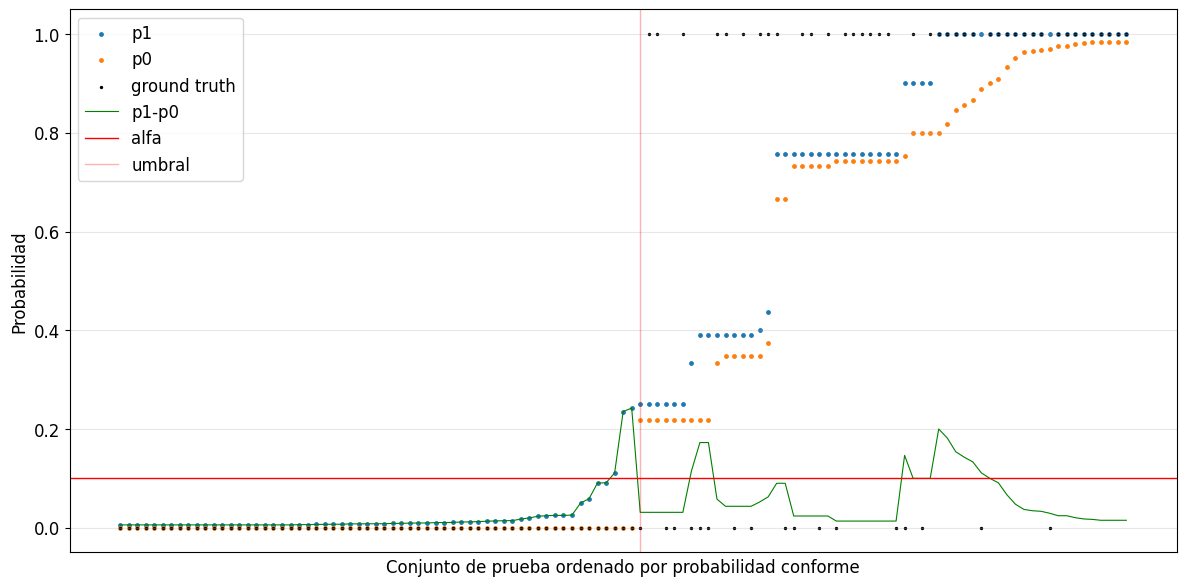

In [30]:
# Visualizamos
fig, ax = plt.subplots(figsize=(12, 6))

plt.scatter(x=pred_df.index, y=pred_df['p1'], label='p1', s=6)
plt.scatter(x=pred_df.index, y=pred_df['p0'], label='p0', s=6)
plt.scatter(x=pred_df.index, y=pred_df['metabolic_syndrome'], label='ground truth', s=2, color='black')
plt.plot(pred_df.index, pred_df["width_of_prediction_interval"], label="p1-p0", lw=0.8, color="green")
plt.axhline(y=alpha, color='red', linewidth=1, label='alfa')
plt.axvline(x=index_threshold, color='red', linewidth=1, label='umbral', alpha=0.3)

plt.legend()
plt.ylabel("Probabilidad")
plt.xlabel("Conjunto de prueba ordenado por probabilidad conforme")
plt.xticks([])
plt.grid(alpha=0.3)
plt.tight_layout(pad=1)
plt.show()

Aquellas predicciones que están a la derecha de la línea vertical son las que el modelo clasifica como 1. Se pueden contar los 17 Falsos Positivos que arroja el modelo con los puntos de *ground truth* que aparecen en y=0 a la derecha de la línea del umbral. La línea que corresponde a la anchura de los intervalos (p1-p0) es la de color verde. Pacientes cuya línea verde sobrepasa la línea horizontal de alfa (0,1) no han obtenido una predicción confiable y podemos decicir no automatizarlas. Es decir, podemos decidir rechazar clasificar aquellas observaciones cuya incertidumbre sea $\geqslant \alpha$, ya que no es recomendable que su clasificación se automatice con este modelo y deberían ser remitidas a personas expertas en medicina.

Para finalizar, vamos a aplicar explicabilidad en algunas predicciones para la conformalización con IVAP. Podemos identificar en el gráfico anterior algunos casos a analizar detenidamente: son interesantes aquellas predicciones no confiables (intervalos grandes) que además tienen alta probabilidad de diagnóstico positivo, sobretodo si alguno de estos casos coincide con alguno de los Falsos Positivos. Una respuesta incorrecta no es necesariamente problemática, [pero una respuesta incorrecta con un alto nivel de confianza sí lo es, especialmente para aplicaciones críticas](https://imerit.net/blog/a-comprehensive-introduction-to-uncertainty-in-machine-learning-all-una/). Identificaremos además en qué pacientes hay más incertidumbre en la predicción y emplearemos técnicas de XAI.

## XAI local

En el cuaderno anterior aplicamos LIME, DiCE y SHAP al modelo como ténicas de XAI locales a algunas predicciones de nuestro bosque aleatorio. Nos centraremos ahora en SHAP para generar nuevas explicaciones.

Empezamos tomando dos pacientes que el modelo ha clasificado con gran confianza, con y sin diagnóstico de síndrome metabólico:

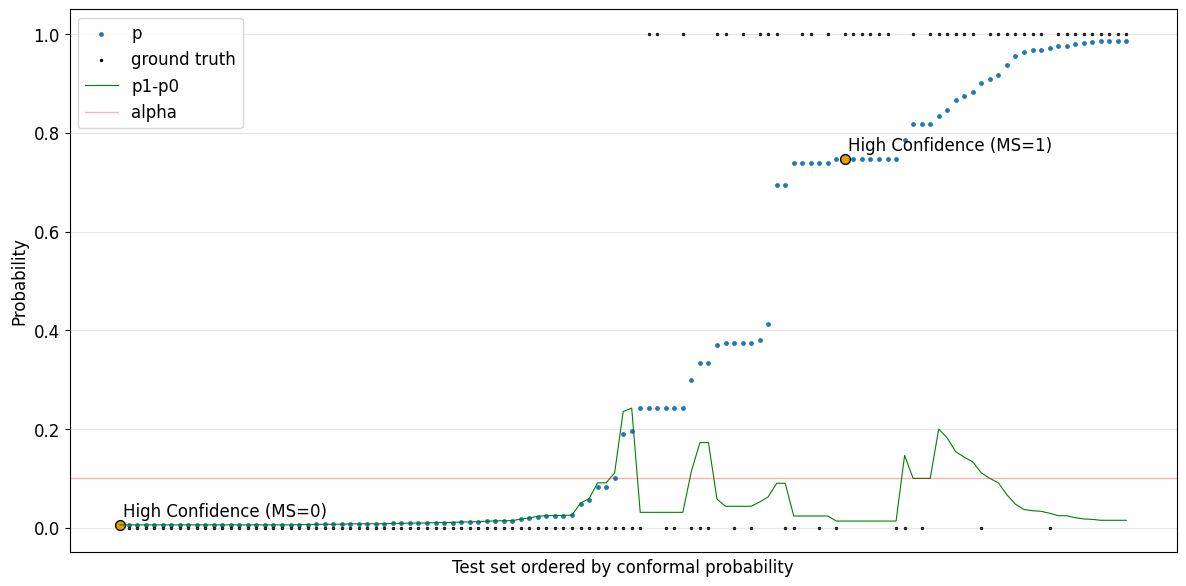

In [31]:
# Primer caso: persona sana, el modelo está muy seguro de clasificarla como sana
case_0_high_confidence = pred_df[pred_df['metabolic_syndrome'] == 0].loc[
    pred_df[pred_df['metabolic_syndrome'] == 0]['width_of_prediction_interval'].idxmin()
]

# Segundo caso: persona con síndrome metabólico, el modelo está muy seguro de clasificarla así
case_1_high_confidence = pred_df[pred_df['metabolic_syndrome'] == 1].loc[
    pred_df[pred_df['metabolic_syndrome'] == 1]['width_of_prediction_interval'].idxmin()
]

special_cases = [
    {'index': case_0_high_confidence.name, 'label': 'High Confidence (MS=0)'},
    {'index': case_1_high_confidence.name, 'label': 'High Confidence (MS=1)'}
]

# Visualizamos estos casos
plot_case(pred_df, special_cases)

In [32]:
# Generamos el explainer para calcular los valores SHAP
# Como SHAP no soporta el tipo de objeto que devuelve FixedThresholdClassifier, usamos el modelo original
explainer = shap.TreeExplainer(model)

# Inicializamos la visualización JavaScript
shap.initjs()

Mostremos la explicación de SHAP para el primer caso:

In [33]:
plot_case_xai(explainer, X_test.loc[[case_0_high_confidence['index']]])

El modelo muestra confianza total en diagnosticar como sana a esta persona, lo que está justificado con valores "bajos" de la circunferencia abdominal, los triglicéridos, el colesterol y que sea un hombre.

Para el segundo caso, donde el modelo está muy seguro del diagnóstico de síndrome metabólico:

In [34]:
plot_case_xai(explainer, X_test.loc[[case_1_high_confidence['index']]])

Aquí tienen más peso los valores más altos de la circunferencia abdominal, la edad, el azúcar en sangre y `UrAlbCr`. Veamos entonces ahora que ocurre con aquellos casos para los que el modelo estaría más inseguro:

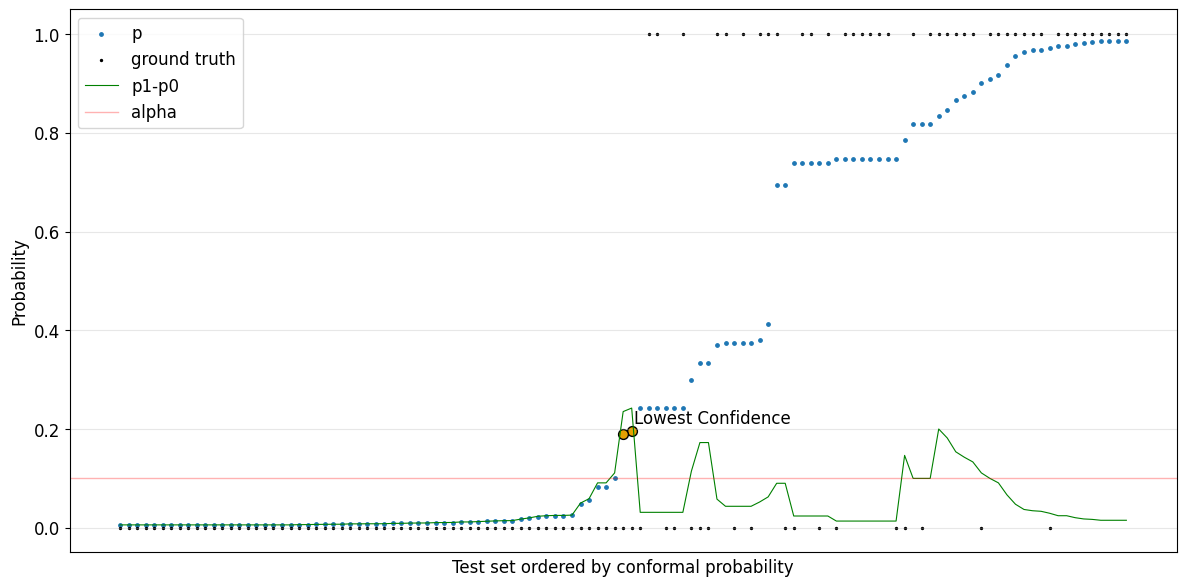

In [35]:
# Tercer y cuarto casos: pacientes más difíciles de predecir
cases_lowest_confidence = pred_df.sort_values(by='width_of_prediction_interval', ascending=False).head(2)

special_cases = [
    {'index': cases_lowest_confidence.iloc[0].name, 'label': 'Lowest Confidence'},
    {'index': cases_lowest_confidence.iloc[1].name, 'label': ''}
]

# Visualizamos estos casos
plot_case(pred_df, special_cases)

Estas dos predicciones se corresponden evidentemente con los picos más altos de la línea de incertidumbre. Mostremos las explicaciones de SHAP para ambos casos, que el modelo clasificó como personas sanas (estando detrás de la línea vertical que vimos del umbral) y acertó: 

In [36]:
plot_case_xai(explainer, X_test.loc[[cases_lowest_confidence.iloc[0]['index']]])

In [37]:
plot_case_xai(explainer, X_test.loc[[cases_lowest_confidence.iloc[1]['index']]])

Ambas personas (un hombre el primero y una mujer la segunda, de la misma edad) tienen valores muy similares de las *features* que contribuyen a las clases y, de hecho, obtienen la misma puntuación final. Parece curioso como el mismo valor de `Age`, en el primer caso contribuye a la puntuación para el diagnóstico positivo y, en el segundo, a la puntuación contratria.

Por último, vamos a ver esas predicciones que, siendo poco confiables, tienen una alta probabilidad de diagnóstico y, en particular, un Falso Positivo:

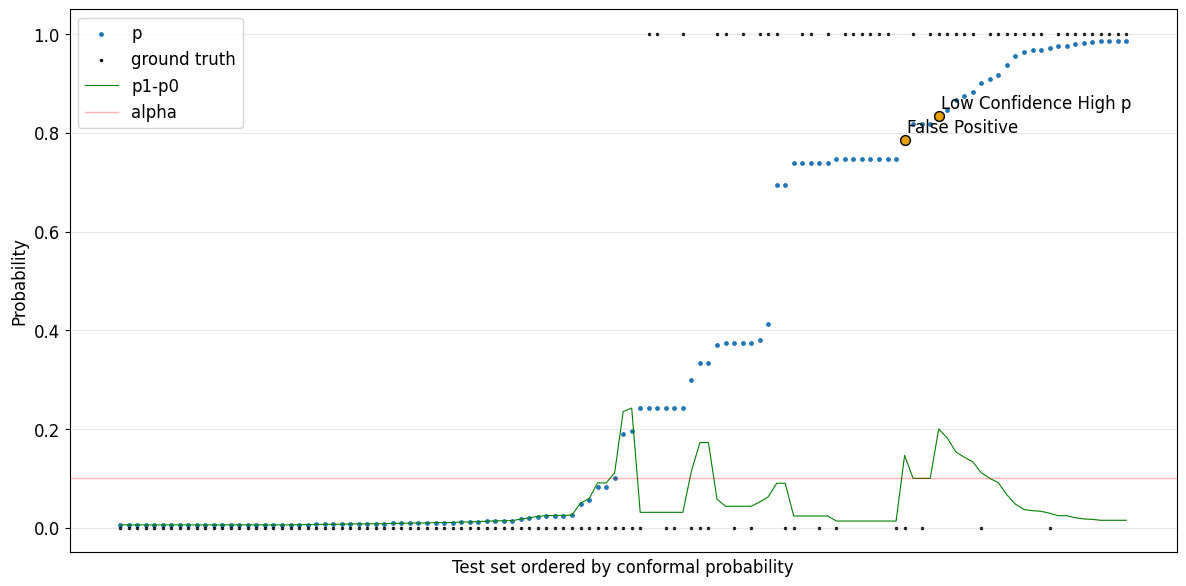

In [38]:
# Casos de gran incertidumbre
cases_lowest_confidence = pred_df[pred_df['width_of_prediction_interval'] >= alpha]

# Quinto caso: gran incertidumbre con síndrome metabólico y con alta probabilidad conforme de síndrome metabólico
case_1_lowest_confidence = None

# Sexto caso: Falso Positivo (gran incertidumbre de una persona sana con alta probabilidad)
case_1_lowest_confidence_FP = None

# Comparamos con la predicción del modelo
for i, row in cases_lowest_confidence.iterrows():
    pred = model_t.predict(X_test.loc[[row['index']]])[0]
    
    # Falso Positivo
    if row['metabolic_syndrome'] == 0 and pred == 1:
        case_1_lowest_confidence_FP = row
        # Si también hemos encontrado case_1_lowest_confidence paramos
        if case_1_lowest_confidence is not None:
            break

    if row['metabolic_syndrome'] == 1 and pred == 1:
        case_1_lowest_confidence = row
        # Si también hemos encontrado case_1_lowest_confidence_FP paramos
        if case_1_lowest_confidence_FP is not None:
            break

special_cases = [
    {'index': case_1_lowest_confidence.name, 'label': 'Low Confidence High p'},
    {'index': case_1_lowest_confidence_FP.name, 'label': 'False Positive'}
]

plot_case(pred_df, special_cases=special_cases)

Empezamos mostrando la explicación para nuestro quinto caso, una persona con síndrome metabólico de la que el modelo no está muy seguro, pero que tiene una alta probabilidad conforme:

In [39]:
plot_case_xai(explainer, X_test.loc[[case_1_lowest_confidence['index']]])

Corresponde al caso de una mujer de 27 años con unos valores muy altos de triglicéridos, pero que el modelo no considera con obesidad central.

Finalmente, el último caso, un Falso Positivo: el modelo ha diagnosticado con síndrome metabólico a una persona sana, pero de la que no está muy seguro:

In [40]:
plot_case_xai(explainer, X_test.loc[[case_1_lowest_confidence_FP['index']]])

Tenemos a un hombre con unos valores bajos de triglicéridos, pero con valores superiores a la media en aquellos atributos principales que contribuyen al diagnóstico positivo. Curiosamente, también unos ingresos mensuales de $9.000 suman a ello según el modelo. Podríamos ahora emplear DiCE para ver si obtenemos algun ejemplo contrafáctico que nos de alguna pista sobre la influencia de esta variable.

In [41]:
# Configuramos el dataset para DiCE
train_dataset = pd.DataFrame(X_train, columns = X_train.columns)
train_dataset['MetabolicSyndrome'] = y_train

d = dice.Data(dataframe = train_dataset, 
              continuous_features= ['Age', 'Income', 'WaistCirc', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides'], 
              outcome_name = 'MetabolicSyndrome')

In [42]:
# Preparamos el modelo
m = dice.Model(model = model, model_type='classifier', backend="sklearn")

In [43]:
# Creamos la instancia del explainer DiCE con genetic que daba resultados más realistas
exp_genetic = dice.Dice(d, m, method="genetic")

In [44]:
# Creamos 3 ejemplos contrafactuales para el cambio de diagnóstico (a persona sana)
dice_exp = exp_genetic.generate_counterfactuals(X_test.iloc[[11]], 
                                  total_CFs=3, 
                                  features_to_vary=['Income', 'WaistCirc'],
                                  desired_class="opposite")  

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.51it/s]


In [45]:
# Visualizamos la counterfactual explanation
dice_exp.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 1)


,Sex_Male,Marital_Divorced,Marital_Married,Marital_Separated,Marital_Single,Marital_Unknown,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,...,Race_White,Age,Income,WaistCirc,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,0.000,63,9000.000,112.200,11.430,6.800,109,50,66,1



Diverse Counterfactual set (new outcome: 0)


,Sex_Male,Marital_Divorced,Marital_Married,Marital_Separated,Marital_Single,Marital_Unknown,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,...,Race_White,Age,Income,WaistCirc,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,101.9,11.4,-,-,-,-,0.0
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,101.4,11.4,-,-,-,-,0.0
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,98.9,11.4,-,-,-,-,0.0


Desafortunamente, perturbando únicamente `Income` no lanza resultados. Tan pronto como añadimos `WaistCirc` encuentra ejemplos donde con unos 10 cm menos de circunferencia abdominal clasificaría como sano a este paciente.

## Conclusiones

El objetivo de este cuaderno ha sido aplicar un método de UQ para abordar la incertidumbre en las predicciones arrojadas por un bosque aleatorio, que se ha elegido por su capacidad para minimizar los Falsos Negativos en la tarea de clasificación binaria para la predicción del diagnóstico de síndrome metabólico. Con tal fin, se estableció inicialmente el nivel de significación $alpha = 0,1$, para una confianza del 90%. Esto se traduce en calcular, para todas las predicciones del modelo, un rango de valores, el llamado intervalo de predicción, que con la probabilidad del 90% incluya el valor verdadero. El requisito para llevarlo a cabo es disponer de predicciones probabilísticas bien calibradas.

Para la calibración del modelo se ha empleado Venn-ABERS, una particularización de *conformal prediction*, que ha permitido convertir las *raw scores* arrojadas en verdaderas probabilidades y obtener así intervalos de predicción con garantía de cobertura para la cuantificación de la incertidumbre. 

En cuanto a la calibración, pudimos constatar además con otras técnicas, como *Platt scaling* e *isotonic regression*, que ya se había conseguido un modelo relativamente bien calibrado. En este sentido, la Predicción Conforme consiguió mejorar las métricas de rendimiento, logrando capturar todos los casos diagnosticados con síndrome metabólico (ningún Falso Negativo).

Gracias a los intervalos de predicción que se han podido obtener con *Venn-ABERS conformal prediction*, se consideraron confiables aquellas predicciones cuyo intervalo tuviera una anchura menor de 0,1. Aquellas con más incertidumbre tienen los intervalos más anchos. Ahora podemos decidir confiar en estos casos y recurrir a una solución diferente cuando la confianza informada sea baja. En la realidad, este tipo de solución puede consistir en lanzar otro modelo de aprendizaje automático más especifíco, para casos con pacientes con esas características, o se puede implementar una señal de *fallback* que indicaría que el modelo prefiere no predecir un caso y se requeriría una persona experta en medicina, o se podría pedir directamente otra prueba médica, entre otras opciones.